In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mat73
from scipy.io import loadmat
import os
import time
import collections
from search import Search
from utils import Utils, Struct
from individual import Individual
from initialization import Initialization
import random
random.seed(42)

In [2]:
dfs = []
repeated_columns = []
unique_columns = []
path = '../../results/permutation/'
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
for file_name in files:
    df = pd.read_csv('../../results/permutation/' + file_name, delimiter=';', header=0, converters={i: str for i in range(100)})
    print(f"df {file_name} - rows: {len(df)} - columns: {len(df.columns)}")

    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
columns_to_add = ["ls_improved_solution", "ls_best_sol", "ls_best_sol_gap", "ls_total_time", "ls_sol_values", "ls_individuals_hashes", "local_search_method", 
"pr_best_sol", "pr_best_sol_gap", "pr_total_time", "pr_sol_values", "pr_individuals_hashes", "path_relinking_method", "improvement_msg"]
for column in columns_to_add:
    df[column] = ""

df.to_csv('../../results/permutation/compiled/results_until280.csv', index=False, sep=";")
df = pd.read_csv('../../results/permutation/compiled/results_until280.csv', delimiter=';', header=0, converters={i: str for i in range(100)})
print(f"df compiled - rows: {len(df)} - columns: {len(df.columns)}, columns added: {len(columns_to_add)}")

df permutation_instances_180-x_a_240-x.csv - rows: 90 - columns: 44
df permutation_instances_280-x.csv - rows: 30 - columns: 44
df permutation_instances_40-x_a_140-x.csv - rows: 150 - columns: 44
df compiled - rows: 270 - columns: 58, columns added: 14


In [3]:
df[:1]

,experiment_id,execution_id,seed,instance,n,m,s,best_known_result,max_generations,max_generations_without_change,...,ls_sol_values,ls_individuals_hashes,local_search_method,pr_best_sol,pr_best_sol_gap,pr_total_time,pr_sol_values,pr_individuals_hashes,path_relinking_method,improvement_msg
0,0,1671556753,879761,Instance_180_1.mat,180,45,90,-2.0571155641648304,20000,10000,...,,,,,,,,,,


In [4]:
def perform_improvement(path_to_csv, path_to_save, time_to_search, n_individuals, local_search_method = "LSBI", path_relinking_method = "backward"):
    df = pd.read_csv(path_to_csv, delimiter=";", converters={i: str for i in range(100)}) # set the path to the results.csv to get chromosomes to perform improvements file here
    for row in df.itertuples():
        improvement_msg = ""
        instance = loadmat(os.path.join("../../instances/", row.instance))
        instance_name = row.instance
        known_result = mat73.loadmat(os.path.join("../../known_results", "x_ls_" + instance_name.replace("Instance_", "")))
        best_known_Z = Search.ldet_objval(instance["A"], known_result["x_ls"].reshape(-1,1))
        start = time.time()
        A = instance["A"]
        n = int(row.n)
        s = int(row.s)
        encoding = "binary"
        env=Struct({"A": A, "n": n, "s": s, "encoding": encoding})

        hashes = np.unique(row.elite_hash.split(","))
        chromosomes = [Utils.hash_2_chromosome(h, n) for h in hashes][:n_individuals]
        # raw_chromosomes =  row.improvement_candidates.split(",")
        # chromosomes = [np.array(list(c), dtype=int).reshape(-1,1) for c in raw_chromosomes][:n_individuals]
        individuals = [Individual(chromosome=c, environment=env) for c in chromosomes]
        
        if len(chromosomes) < 1:
            improvement_msg = f"Skiped LS at row with {len(chromosomes)} chromosomes. "
            df.loc[row.Index, "improvement_msg"] = improvement_msg
        else:
            # Local Search
            ls_start = time.time()
            ls_individuals, ls_solutions = Search.local_search(environment=env, individuals = individuals, max_time = time_to_search, best_sol = best_known_Z, local_search_method = local_search_method)
            df.loc[row.Index, "ls_improved_solution"] = str(max(ls_solutions) > float(row.best_solution_found))
            df.loc[row.Index, "ls_best_sol"] = str(max(ls_solutions))
            df.loc[row.Index, "ls_best_sol_gap"] = str((max(ls_solutions) - best_known_Z)/abs(best_known_Z))
            df.loc[row.Index, "ls_total_time"] = str(time.time()-ls_start)
            df.loc[row.Index, "ls_sol_values"] = ",".join([str(sol) for sol in ls_solutions])
            df.loc[row.Index, "ls_individuals_hashes"] = ",".join([str(ind.individual_hash) for ind in ls_individuals])
            df.loc[row.Index, "local_search_method"] = str(local_search_method)

        if len(chromosomes) < 2:
            improvement_msg = f"Skiped PR at row with {len(chromosomes)} chromosomes. "
            df.loc[row.Index, "improvement_msg"] = improvement_msg
        else:
            # Path Relinking
            pr_hashes, pr_solutions, pr_time = Search.path_relinking(chromosomes, A, path_relinking_method)
            df.loc[row.Index, "pr_improved_solution"] = str(max(pr_solutions) > float(row.best_solution_found))
            df.loc[row.Index, "pr_best_sol"] = str(max(pr_solutions))
            df.loc[row.Index, "pr_best_sol_gap"] = str((max(pr_solutions) - best_known_Z)/abs(best_known_Z))
            df.loc[row.Index, "pr_total_time"] = str(pr_time)
            df.loc[row.Index, "pr_sol_values"] = ",".join([str(s) for s in pr_solutions])
            df.loc[row.Index, "pr_individuals_hashes"] = ",".join([str(h) for h in pr_hashes])
            df.loc[row.Index, "path_relinking_method"] = str(path_relinking_method)


        print(f"Row Index: {row.Index} finished in {time.time()-start}.")

    df.to_csv(path_to_save, index=False, sep=";", mode="a", header=True)


path_to_csv = "../../results/permutation/compiled/results_until280.csv" # set the path to the results.csv to get chromosomes to perform improvements file here
path_to_save = "../../results/permutation/compiled/results_improved_until280.csv"
ls_max_time = 120
perform_improvement(path_to_csv, path_to_save, ls_max_time, 50)

[Individual|fitness:-2.082277087874944|obj_func:-2.082277087874944|s:90|num_1s:90|chromosome:too long]
Row Index: 0 finished in 4.675487279891968.
[Individual|fitness:-2.0427498562262087|obj_func:-2.0427498562262087|s:90|num_1s:90|chromosome:too long]
Row Index: 1 finished in 42.03985095024109.
[Individual|fitness:-2.050293125571966|obj_func:-2.050293125571966|s:90|num_1s:90|chromosome:too long]
Row Index: 2 finished in 18.474981546401978.
[Individual|fitness:-1.9884438913791076|obj_func:-1.9884438913791076|s:90|num_1s:90|chromosome:too long]
Row Index: 3 finished in 13.548173904418945.
[Individual|fitness:-2.134193563136834|obj_func:-2.134193563136834|s:90|num_1s:90|chromosome:too long]
Row Index: 4 finished in 4.69900369644165.
[Individual|fitness:-2.1149652108934323|obj_func:-2.1149652108934323|s:90|num_1s:90|chromosome:too long]
Row Index: 5 finished in 5.154044151306152.
[Individual|fitness:-2.080458570029688|obj_func:-2.080458570029688|s:90|num_1s:90|chromosome:too long]
Row Inde

In [12]:
row = df.iloc[112]
instance = loadmat(os.path.join("../../instances/", row.instance))
instance_name = row.instance
known_result = mat73.loadmat(os.path.join("../../known_results", "x_ls_" + instance_name.replace("Instance_", "")))
best_known_Z = Search.ldet_objval(instance["A"], known_result["x_ls"].reshape(-1,1))
start = time.time()
A = instance["A"]
n = int(row.n)
s = int(row.s)
encoding = "binary"
env=Struct({"A": A, "n": n, "s": s, "encoding": encoding})

hashes = np.unique(row.elite_hash.split(","))
chromosomes = [Utils.hash_2_chromosome(h, n) for h in hashes][:50]

pr_hashes, pr_solutions, pr_time = Search.path_relinking(chromosomes, A, "backward")

In [42]:
row.best_known_result

'0.8112098542748618'

In [40]:
pr_chromosomes = [Utils.hash_2_chromosome(h, n) for h in pr_hashes]

In [41]:
[sum(c)==s for c in pr_chromosomes]

[array([ True]),
 array([ True]),
 array([ True]),
 array([ True]),
 array([ True])]

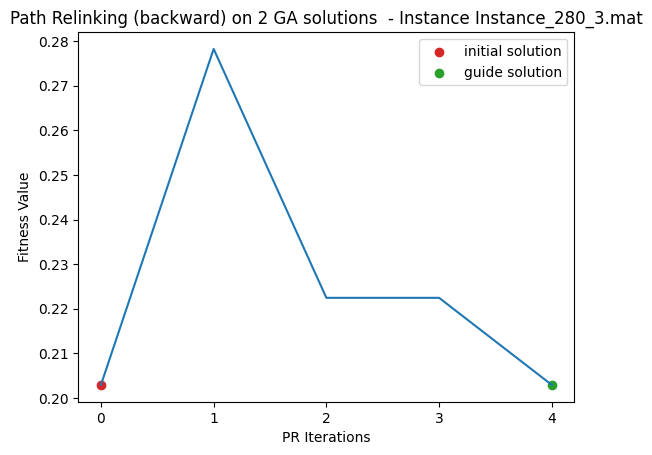

[0.20293312596203614, 0.2782326472512951, 0.22245037593317324, 0.22245037593317324, 0.20293312596203614]


In [39]:
plt.plot(pr_solutions)
plt.xticks(range(len(pr_solutions)))
plt.scatter([0], [pr_solutions[0]], color="tab:red", label="initial solution")
plt.scatter([4], [pr_solutions[-1]], color="tab:green", label="guide solution")
plt.legend()
plt.xlabel("PR Iterations")
plt.ylabel("Fitness Value")
plt.title(f"Path Relinking (backward) on 2 GA solutions  - Instance {row.instance}")
plt.show()
print(pr_solutions)

[0.22245037593317324, 0.20293312596203614]


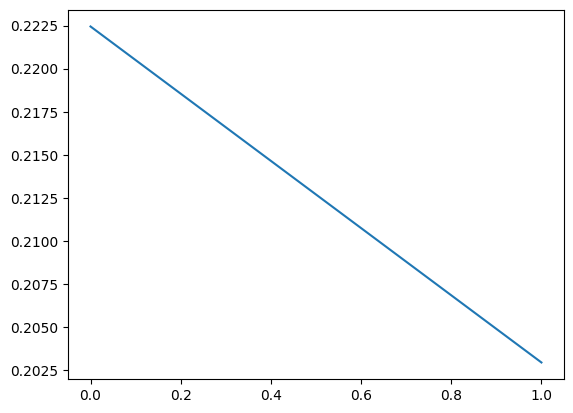

In [22]:
unique_chromosomes = chromosomes
stop=False
for i in range(n):
        for j in range (i+1,n):
            idx = [i,j]
            id_max = np.argmax([Search.ldet_objval(A, unique_chromosomes[i]), Search.ldet_objval(A, unique_chromosomes[j])])
            best_chromosome = unique_chromosomes[idx[id_max]]
            worst_chromosome = unique_chromosomes[1-idx[id_max]]
            hashes, solutions = Search.pr_unidirectional(initial=best_chromosome, guide=worst_chromosome, A=A)
            if max(solutions) > float(row.best_solution_found):
                print(solutions)
                plt.plot(range(len(solutions)), solutions)
                stop=True
                break
        if stop:
            break
            